# Pretraining

## Imports and Constants

In [1]:
import tiktoken
import torch
from importlib.metadata import version
from previous_chapters import GPTModel,generate_text_simple
from torch.utils.data import Dataset, DataLoader

In [2]:
TOKENIZER = tiktoken.get_encoding("gpt2")
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}
torch.manual_seed(123)

In [3]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [4]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [5]:
total_chars = len(text_data)
total_tokens = len(TOKENIZER.encode(text_data))
total_chars,total_tokens

(20479, 5145)

## Training and Validation Loss

### Set Up

In [6]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
    
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [7]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [8]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [9]:
print("Train Loader:")
for x,y in train_loader:
    print(x.shape,y.shape)

print("Val Loader:")
for x,y in val_loader:
    print(x.shape,y.shape)

Train Loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Val Loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [10]:
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch,target_batch,model,device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

In [11]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device)
    val_loss = calc_loss_loader(val_loader,model,device)
train_loss,val_loss

(10.994007958306206, 11.03604793548584)

### Training Loop

In [13]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [14]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=TOKENIZER
)

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

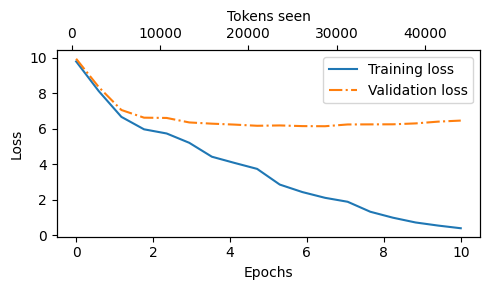

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## Decoding Strategies

In [16]:
model.to("cpu")
model.eval()
#tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you",TOKENIZER),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids,TOKENIZER))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


### Temperature Scaling

In [17]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [18]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [19]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [20]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [0.1,1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

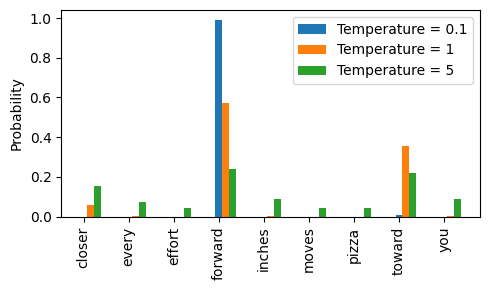

In [21]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

#### Ex 5.1

In [22]:
print_sampled_tokens(scaled_probas[0])
print("------------------")
print_sampled_tokens(scaled_probas[1])
print("------------------")
print_sampled_tokens(scaled_probas[2])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
------------------
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
------------------
165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


In [23]:
scaled_probas[0][6] * 1_000,scaled_probas[1][6] * 1_000,scaled_probas[2][6] * 1_000

(tensor(2.9718e-35), tensor(0.1012), tensor(42.9980))

### Combining Temperature Scaling and Top-K Sampling

In [24]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [25]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", TOKENIZER),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, TOKENIZER))

Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


### Ex 5.2

In [26]:
temperatures = [0.1,0.3,1.2,3.6]
for temp in temperatures:
    token_ids = generate(
        model=model,
        idx=text_to_token_ids("Every effort moves you", TOKENIZER),
        max_new_tokens=15,
        context_size=GPT_CONFIG_124M["context_length"],
        top_k=25,
        temperature=temp
    )

    print("Output text:\n", token_ids_to_text(token_ids, TOKENIZER))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted
Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sev
Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony.


Output text:
 Every effort moves you-light chucked-rooms host able of an the-century pictures too


In [27]:
top_ks = [5,10,15,20,25,50]
for k in top_ks:
    token_ids = generate(
        model=model,
        idx=text_to_token_ids("Every effort moves you", TOKENIZER),
        max_new_tokens=15,
        context_size=GPT_CONFIG_124M["context_length"],
        top_k=k,
        temperature=1.4
    )

    print("Output text:\n", token_ids_to_text(token_ids, TOKENIZER))

Output text:
 Every effort moves you know," was one that my hostess it were days when I felt it
Output text:
 Every effort moves you know began to go a little: they.



"I
Output text:
 Every effort moves you?"
As he--forming, so a smile that lifted the frame called
Output text:
 Every effort moves you know where to go on painting because he _ with a deprecating last
Output text:
 Every effort moves you?"

"Yes-- Mrs. The mere outline of the tips's
Output text:
 Every effort moves you?"


Ited to meburn's't dab the head in


### Ex 5.3

Disabling Temperature, or Reducing it to the top-1

#### Deterministic Samples

In [28]:
generate_and_print_sample(model,TOKENIZER,device,"Every effort moves you")

Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed luncheon-table, when, on a later day, I had again run over from Monte Carlo; and Mrs. Gis


In [29]:
generate_and_print_sample(model,TOKENIZER,device,"Every effort moves you")

Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed luncheon-table, when, on a later day, I had again run over from Monte Carlo; and Mrs. Gis


#### Stochastic Sampling

In [30]:
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [31]:
#torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", TOKENIZER),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=None,
    temperature=-1
)

print("Output text:\n", token_ids_to_text(token_ids, TOKENIZER))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed luncheon-table, when, on a later day, I had again run over from Monte Carlo; and Mrs. Gis


In [32]:

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", TOKENIZER),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=None,
    temperature=-1
)

print("Output text:\n", token_ids_to_text(token_ids, TOKENIZER))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed luncheon-table, when, on a later day, I had again run over from Monte Carlo; and Mrs. Gis


In [33]:
#torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", TOKENIZER),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=1,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, TOKENIZER))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed luncheon-table, when, on a later day, I had again run over from Monte Carlo; and Mrs. Gis


In [34]:
#torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", TOKENIZER),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=1,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, TOKENIZER))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed luncheon-table, when, on a later day, I had again run over from Monte Carlo; and Mrs. Gis


In [35]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", TOKENIZER),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=0
)

print("Output text:\n", token_ids_to_text(token_ids, TOKENIZER))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed luncheon-table, when, on a later day, I had again run over from Monte Carlo; and Mrs. Gis


In [36]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", TOKENIZER),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=0
)

print("Output text:\n", token_ids_to_text(token_ids, TOKENIZER))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed luncheon-table, when, on a later day, I had again run over from Monte Carlo; and Mrs. Gis


## Loading and Saving Weights

In [44]:
torch.save(model.state_dict(), "model.path")

In [45]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.path", map_location=device))
model.eval()

/var/folders/k5/zwq_p6cs6hz9zlccpbdjbgwr0000gn/T/ipykernel_13324/2720688525.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.path"

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [46]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_opt.pth"
)

In [47]:
checkpoint = torch.load("model_and_opt.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## Loading from OpenAI

In [51]:
!pip3 install tensorflow tqdm

  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.1.24-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.8.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 1.4 MB/s eta 0:00:00
  Using cached Markdown-3.7-py3-none-any.whl.metadata (7.0 kB)
  Using cached tensorboard_data_serv

In [52]:
from gpt_download import download_and_load_gpt2

In [53]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 23.8kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.46MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 25.0kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:21<00:00, 23.3MiB/s] 
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 880kiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 1.59MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.49MiB/s]


In [54]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [55]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [56]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [57]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [58]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [59]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", TOKENIZER).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, TOKENIZER))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?




## End Exercises

### 5.5

In [62]:
#gpt
optimizer = torch.optim.AdamW(gpt.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, tokens_seen = train_model_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=TOKENIZER
)

Ep 1 (Step 000000): Train loss 3.918, Val loss 3.827
Ep 1 (Step 000005): Train loss 2.875, Val loss 3.594
Every effort moves you forward, and you are left behind.  "I have always felt that my work was the only way to get to the end. I had always felt that my work was the only way to get to the end. I had always felt that


### 5.6

In [63]:
settings, params = download_and_load_gpt2(model_size="355M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 32.4kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 1.65MiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 47.8kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [01:51<00:00, 12.7MiB/s] 
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 1.73MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:00<00:00, 2.20MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 1.54MiB/s]


In [64]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 1024, 'n_head': 16, 'n_layer': 24}


In [65]:
settings, params = download_and_load_gpt2(model_size="355M", models_dir="gpt2")

# Copy the base configuration and update with specific model settings
model_name = "gpt2-medium (355M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval()

optimizer = torch.optim.AdamW(gpt.parameters(), lr=0.0004, weight_decay=0.1)

"""
num_epochs = 5
train_losses, val_losses, tokens_seen = train_model_simple(
    gpt, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=TOKENIZER
)
"""

Ep 1 (Step 000000): Train loss 9.400, Val loss 9.880
Ep 1 (Step 000005): Train loss 7.514, Val loss 7.743
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000010): Train loss 6.366, Val loss 6.753
Ep 2 (Step 000015): Train loss 6.188, Val loss 6.634
Every effort moves you the the, the, the, the the, the, the, the, the, the, the, the, the, the, the the, the the, the, the, the, the, the, the, the, the,
Ep 3 (Step 000020): Train loss 6.021, Val loss 6.650
Ep 3 (Step 000025): Train loss 5.894, Val loss 6.639
Every effort moves you.                                                 
Ep 4 (Step 000030): Train loss 5.921, Val loss 6.627
Ep 4 (Step 000035): Train loss 5.804, Val loss 6.650
Every effort moves you, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the
Ep 5 (Step 000040): Train loss 5.746, Val loss 6.689
Every effort moves you, the,,,,,, the I, the,,,, the,,,,,, the,,,,, the,, t

In [66]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", TOKENIZER).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, TOKENIZER))

Output text:
 Every effort moves you his up."

 Rick he,_."

 . was the, him was, in with-- about-- I


In [68]:
settings, params = download_and_load_gpt2(model_size="355M", models_dir="gpt2")

# Copy the base configuration and update with specific model settings
model_name = "gpt2-medium (355M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval()

load_weights_into_gpt(gpt, params)
gpt.to(device)

torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", TOKENIZER).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, TOKENIZER))

File already exists and is up-to-date: gpt2/355M/checkpoint
File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json
File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index
File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe
Output text:
 Every effort moves you toward balance." But it seems quite different at any speed or type of energy.

If you're trying to get energy


## Workspace

### Analyzing The Training Cycle

In [60]:
train_loader_exam = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader_exam = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

def calc_loss_batch_exam(input_batch,target_batch,model,device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)

    print("input_batch",input_batch.size())
    print("target_batch",target_batch.size())
    print("logits",logits.size(),logits.flatten(0,1).size())
    print("target_batch",target_batch.size(),target_batch.flatten().size())

    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

def calc_loss_loader_exam(data_loader,model,device,num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch_exam(
                input_batch,target_batch,model,device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

model_exam = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_exam.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader_exam(train_loader_exam,model_exam,device)
    val_loss = calc_loss_loader_exam(val_loader_exam,model_exam,device)
#train_loss,val_loss

input_batch torch.Size([2, 256])
target_batch torch.Size([2, 256])
logits torch.Size([2, 256, 50257]) torch.Size([512, 50257])
target_batch torch.Size([2, 256]) torch.Size([512])
input_batch torch.Size([2, 256])
target_batch torch.Size([2, 256])
logits torch.Size([2, 256, 50257]) torch.Size([512, 50257])
target_batch torch.Size([2, 256]) torch.Size([512])
input_batch torch.Size([2, 256])
target_batch torch.Size([2, 256])
logits torch.Size([2, 256, 50257]) torch.Size([512, 50257])
target_batch torch.Size([2, 256]) torch.Size([512])
input_batch torch.Size([2, 256])
target_batch torch.Size([2, 256])
logits torch.Size([2, 256, 50257]) torch.Size([512, 50257])
target_batch torch.Size([2, 256]) torch.Size([512])
input_batch torch.Size([2, 256])
target_batch torch.Size([2, 256])
logits torch.Size([2, 256, 50257]) torch.Size([512, 50257])
target_batch torch.Size([2, 256]) torch.Size([512])
input_batch torch.Size([2, 256])
target_batch torch.Size([2, 256])
logits torch.Size([2, 256, 50257]) tor